# Circuito cuántico para autoencoder

Propuesta para el hackathon es diseñar un circuito cuántico que pueda disminuir el número de variables de imagenes sin perder información y poder trabajar con menos qubits para una clasificación usando el conjunto de datos MNIST.

Se indican a continuación las dependencias necesarias para poder trabajar en este problema.

In [1]:
import numpy as np
# Bibliotecas necesarias de Qiskit 
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter, ParameterVector

#Bliblioteca para la adquisición y preprocesamiento del conjunto MNIST.
import tensorflow as tf

#Bibliotecas para graficar 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Preprocesamiento

Inicializamos las carácteristicas de nuestro circuito cuántico que es el conjunto de datos MNIST, para esto nos apoyamos de tensorflow que ya tiene el conjunto de datos.

Cada conjunto tiene 10 clases : **[0,1,2,3,4,5,6,7,8,9]**,
y van de 0 a 255, por ello nosotros pasamos un proceso de **normalización que va de 0.0 a 1.0**, donde negro representa el fondo y el blanco y escala de gris a los números.



In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Imagenes del conjunto de entrenamiento:", len(x_train))
print("Imagenes del conjunto de entrenamiento:", len(x_test))

Imagenes del conjunto de entrenamiento: 60000
Imagenes del conjunto de entrenamiento: 10000


In [3]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y

In [4]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Imagenes del conjunto de entrenamiento:", len(x_train))
print("Imagenes del conjunto de entrenamiento:", len(x_test))

Imagenes del conjunto de entrenamiento: 12665
Imagenes del conjunto de entrenamiento: 2115


Se representan las imagenes que tienen un tamaño original de 28x28

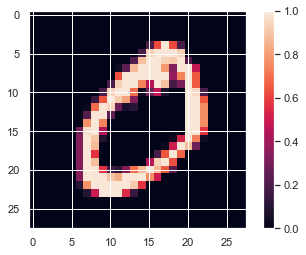

In [5]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### Reducción de la imagen

Tensorflow tiene el método *tf.image.resize* que disminuye las imagenes a partir de los siguientes posibles criteros:

<ul>
<li><b>bilinear</b>: Bilinear interpolation. If antialias is true, becomes a hat/tent filter function with radius 1 when downsampling.</li>
<li><b>lanczos3</b>: Lanczos kernel with radius 3. High-quality practical filter but may have some ringing, especially on synthetic images.</li>
<li><b>lanczos5</b>: Lanczos kernel with radius 5. Very-high-quality filter but may have stronger ringing.</li>
<li><b>bicubic</b>: Cubic interpolant of Keys. Equivalent to Catmull-Rom kernel. Reasonably good quality and faster than Lanczos3Kernel, particularly when upsampling.</li>
<li><b>gaussian</b>: Gaussian kernel with radius 3, sigma = 1.5 / 3.0.</li>
<li><b>nearest</b>: Nearest neighbor interpolation. antialias has no effect when used with nearest neighbor interpolation.</li>
<li><b>area</b>: Anti-aliased resampling with area interpolation. antialias has no effect when used with area interpolation; it always anti-aliases.</li>
<li><b>mitchellcubic</b>: Mitchell-Netravali Cubic non-interpolating filter. For synthetic images (especially those lacking proper prefiltering), less ringing than Keys cubic kernel but less sharp.</li>
    
</ul>


Ejemplo de dicho preprocesamiento de reducción de datos se emplea a continuación con el método nearest y con el tamaño de imagen 8x8.

In [6]:
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

En este punto se tienen imagenes de tamaño 8x8 y se tienen que pasar como un estado de amplitud ya que $8x8 = 64$  y esto nos dará un vector de $2^6$ que recordando el valor 6 es el número de qubits a usar 

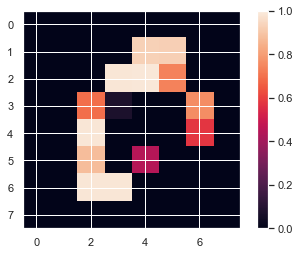

In [7]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [8]:
x_train = x_train_small.reshape(len(x_train_small), 64)
x_test = x_test_small.reshape(len(x_test_small), 64)
x_train.shape,x_test.shape

((12665, 64), (2115, 64))

In [9]:
x_train_small[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.93333333],
        [0.92941176],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.98823529],
        [0.99215686],
        [0.74117647],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.69803922],
        [0.0745098 ],
        [0.        ],
        [0.        ],
        [0.76470588],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.98823529],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.58039216],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.88235294],
        [0.        ],
        [0.44705882],


## De imagen a qubits

Por las capacidades que actualmente se usa CPU para el diseño de circuitos cuánticos en Qiskit, no es posible ocupar todo el conjunto de imagenes, se diseñaron 8 experimentos por lo menos desde 10 iteraciones hasta 50, ocupando las siguientes entradas:

<ul>
    <li>Las 5 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 10 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 12 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 50 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 70 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 100 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 200 primeras imagenes del conjunto de entrenamiento.</li>
    <li>Las 500 primeras imagenes del conjunto de entrenamiento.</li>

</ul>

In [10]:
x_train = (x_train)
x_test = (x_test)

x_train.shape,x_test.shape

((12665, 64), (2115, 64))

Se pasa de la matriz de tamaño 8x8 a un vector de tamaño 64x1 por cada imagen

In [11]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.93333333, 0.92941176, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98823529,
       0.99215686, 0.74117647, 0.        , 0.        , 0.        ,
       0.        , 0.69803922, 0.0745098 , 0.        , 0.        ,
       0.76470588, 0.        , 0.        , 0.        , 0.98823529,
       0.        , 0.        , 0.        , 0.58039216, 0.        ,
       0.        , 0.        , 0.88235294, 0.        , 0.44705882,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.98823529, 0.98823529, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Se elimina las posibles imagenes que no tengan información, es decir, puros 0's para el conjutno de entrenamiento

In [12]:
k = 0

while k < len(x_train):
  a = x_train[k].copy()
  if np.sum(a) == 0.:
    print(k,x_train[k])
    x_train = np.delete(x_train, k, axis=0)
    y_train = np.delete(y_train, k, axis=0)
    k -= 1
  k+=1

Se elimina las posibles imagenes que no tengan información, es decir, puros 0's para el conjutno de testeo

In [13]:
k = 0

while k < len(x_test):
  a = x_test[k].copy()
  if np.sum(a) == 0.:
    print(k,x_test[k])
    x_test = np.delete(x_test, k, axis=0)
    y_test = np.delete(y_test, k, axis=0)
    k -= 1
  k+=1


Ahora se aplicara una renormalización para poder interpretar un vector de estado para pdoer aplicarse en nuestro modelo de circuito cuántico, siguiendo el critero:

$ \frac{vector-de-entrada}{\sqrt{\sum_{i=0}^{n-1} (vector-de-entrada_i)^2}}$,

donde vector-de-entrada  es  el vector de 64x1 que representa una imagen ya sea del conjunto de entrenamiento o de prueba con la finalidad de convertirse en un vector de estado $| \psi \rangle$.

In [14]:
import cmath
def Normalize(row):
  suma = np.sqrt(np.sum(row**2))
  if suma == 0.:
    return 0.0
  row = row/suma
  return row


for i in range(len(x_train)):
    x_train[i] = Normalize(x_train[i])
    
for i in range(len(x_test)):
    x_test[i] = Normalize(x_test[i])
    
print("la suma de los estados de la imagen del conjunto de entrenamiento 0",np.sum(x_train[0]**2))

la suma de los estados de la imagen del conjunto de entrenamiento 0 1.0


# Análisis y Diseño del Autoencoder

Para este trabajo se diseñará los circuitos necesarios para indicar el autoencoder en su versión cuántica.

Para este proceso se consideran 6 qubits que recordando equivalen al vector de estado 64x1, donde usaremos el mapeo por amplitud, y se ocupo por cuestiones de tiempo y recursos 1 sola capa por cada 1.

Más adelante se indicaran el circuito que se uso para esta aplicación pero requiere de 10 paramétros.

In [15]:
n=6
num_layers = 1
params = np.random.random(10*(num_layers))

Se valida que el vector de entrada con indice 0 este normalizado a un vector de estado

In [16]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30173661, 0.30046881, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31948582,
       0.32075362, 0.23961437, 0.        , 0.        , 0.        ,
       0.        , 0.22566856, 0.02408822, 0.        , 0.        ,
       0.24722117, 0.        , 0.        , 0.        , 0.31948582,
       0.        , 0.        , 0.        , 0.18763453, 0.        ,
       0.        , 0.        , 0.2852552 , 0.        , 0.1445293 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.31948582, 0.31948582, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Al ingresar el vector de estado como entrada a una función que genera un circuito cuántico de 6 qubits que usando el método 
`initialize(vectorstate,qubits)` que genera la representación en términos de qubits. 

Una observación de este método es que se puede variar el costo computacional por el tipo de método que se genere, y más si predominan estados con estados 0 de amplitud, generando que los equipos de computo de nuestro equipo fue limitado.

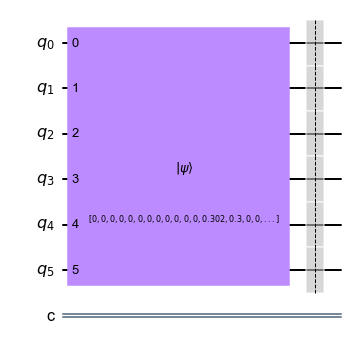

In [17]:
def input_data(n,inputs):
    circuit = QuantumCircuit(n,1)
    circuit.initialize(inputs,range(0,n,1))
    circuit.barrier()
    return circuit
input_data(n,x_train[0]).draw(output="mpl")

En este proceso generamos el circuito variacional cuántico que representa el autoencoder cuántico, consideramos de apoyo el circuito cuántico propuesto en [1], pero algunos problemas daban por el costo computacional por lo que consideramos [2],[3],[4],[5] para generar a partir de varias propuestas de redes tensoriales como peude ser MERA, para nuestro trabajo y con ciertas modificaciones para dejarlo en 6 qubits.

In [18]:
def vqc(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    
    
    parameters = ParameterVector('θ', 10*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n, 1)
    

    
    for layer in range(num_layers):
        for i in range(n):
            circuit.ry(parameters[(layer)+i], i)
        circuit.barrier()

        circuit.cx(2,0)
        circuit.cx(3,1)
        circuit.cx(5,4)
        circuit.barrier()
        
        circuit.ry(parameters[6+(layer)],0)
        circuit.ry(parameters[7+(layer)],1)
        circuit.ry(parameters[8+(layer)],4)
        circuit.barrier()
        
        circuit.cx(4,1)
        circuit.barrier()

        circuit.ry(parameters[9+(layer)], 1)
        circuit.barrier()
        

    
    params_dict = {}
    i = 0
    for p in parameters:
        params_dict[p] = params[i]
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

El circuito de nuestra red tensorial se ve afectada por 10 compuertas $Ry(\theta)$ y 4 $C_{not}$, considerando como costo ligado al número de $C_{not}$ sería de 4.

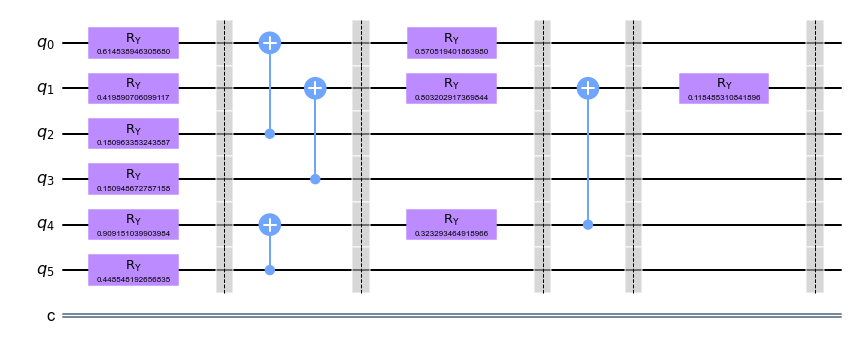

In [19]:
vqc(n,num_layers,params).draw(output="mpl")

Considerando [6] se tiene la oportunidad de usar el Swap-test para buscar el valor de y se identifico de [7] la forma de trabajo de la Swap-Test se comparan dos estados $| \psi \rangle$  y $| \phi \rangle$,  donde el primero es el vector de referencia $| 0 \rangle$  y el segundo los qubits que se quieren eliminar para disminuir variables, estos son $| \phi_0 \phi_1 \rangle$ donde al medirse el qubit que tiene la Hadamard del Swap-Test y este se acerque más al estado $|0 \rangle$ significa que se disminuyó de manera correcta la informacion en $| \phi_0 \phi_1 \rangle$.

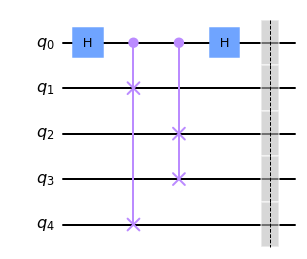

In [20]:
def swap_test(n):
    qubits_values = 2*n+1
    qc = QuantumCircuit(qubits_values)
    qc.h(0)
    for i in range(n):
        qc.cswap(0,i+1,2*n-i)
    qc.h(0)
    qc.barrier()
    return qc
swap_test(2).draw(output="mpl")

El siguiente proceso indica el circuito cuántico variacional dle autoencoder para generar la disminución de dos qubits.

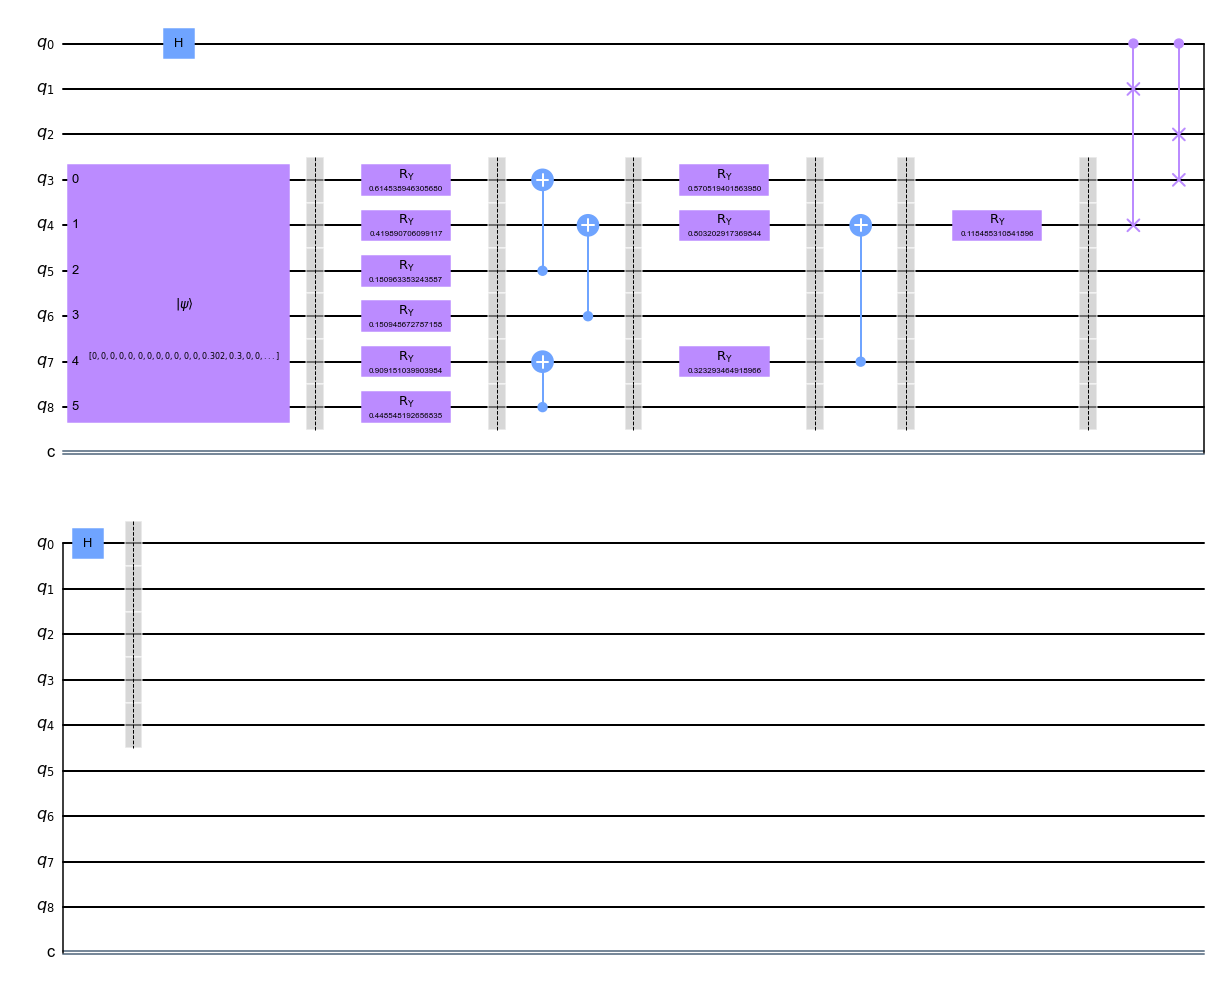

In [21]:
size_reduce = 2
circuit_init = input_data(n,x_train[0])
circuit_vqc = vqc(n,num_layers,params)
circuit_swap_test = swap_test(size_reduce)

circuit_full = QuantumCircuit(n+size_reduce+1,1)

circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw(output="mpl")

Qiskit tiene la propeidad de generar de un circuito cuántico su inverso que es necesario para nosotros al momento de decodificar la disminuci´no de variables al tamaño original del vector de estado. 

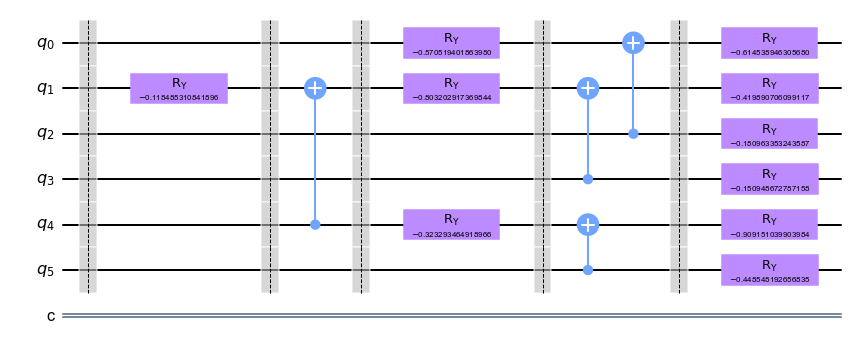

In [22]:
vqc(n,num_layers,params).inverse().draw(output = "mpl")

## Comprimir datos

En este trabajo al no encontrar una manera correecta de usar los optimziadores para un circuito cuántico que utiliza le mapeo por amplitud, se utilizo la libreria scikitlearn por su método de optimización que es el mismo que usan en Qiskit. y también se usa un shuffle para que en cada iteración logre ocupar algunas imagenes nuevas en cada iteración.

In [23]:
from random import shuffle
from scipy.optimize import minimize 

Se uso para identificar el costo de cada entrada por el valor esperado en el eje z, es decir, $\langle z \rangle $, el cuál se define 

$\langle Z \rangle = \langle q | Z | q\rangle =\langle q|0\rangle\langle 0|q\rangle - \langle q|1\rangle\langle 1|q\rangle
=|\langle 0 |q\rangle|^2 - |\langle 1 | q\rangle|^2 $


pero al adecuarl oal criterio del Swap test debe quedar como:


$1 -\langle Z \rangle = 1 - \langle q | Z | q\rangle = 1- [\langle q|0\rangle\langle 0|q\rangle - \langle q|1\rangle\langle 1|q\rangle] = 1 - [|\langle 0 |q\rangle|^2 - |\langle 1 | q\rangle|^2] = 1 - |\langle 0 |q\rangle|^2 + |\langle 1 | q\rangle|^2 $

para mayor información se puede observar en https://qiskit.org/textbook/ch-labs/Lab02_QuantumMeasurement.html

In [24]:
def objective_function(params):
    costo = 0
    shuffle(x_train)
    lenght= 5
    for i in range(lenght):
        circuit_init = input_data(n,x_train[i])
        circuit_vqc = vqc(n,num_layers,params)
        circuit_swap_test = swap_test(size_reduce)

        circuit_full = QuantumCircuit(n+size_reduce+1,1)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        circuit_full.measure(0, 0)
        #qc.draw()
        shots= 8192
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=shots )
        counts = job.result().get_counts()
        probs = {}
        for output in ['0','1']:
            if output in counts:
                probs[output] = counts[output]/shots
            else:
                probs[output] = 0
        costo += (1 +probs['1'] -  probs['0'])
    
    return costo/lenght

for i in range(1):    
    minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6)
    params = minimum.x
    print(" cost: ",objective_function(params))
    print(params)

 cost:  0.2796875
[ 0.62254674  0.26851417  0.18249782  1.72136515  2.0098116  -0.0834305
 -1.52525618  0.47399993 -0.21121215 -0.16145395]


Al finalizar las iteraciones necesarias, depende del número del conjunto de instancia seleccionadas, se pasa por vector de estado por el complejo conjugado de nuestro circuito cuántico, dónde [6] y [7] mencionaban que nos debe dar la información original. Esto se realiza a todo el conjunto de entrenamiento como de prueba.

In [25]:
def compress_result_test(params):
    reduce = []
    for i in range(len(x_test)):
        circuit_init = input_data(n,x_test[i])
        circuit_vqc = vqc(n,num_layers,params)

        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full)
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts()
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs)
        
    return reduce
        
reduce_img =compress_result_test(params)
test_reduce = []
for i in reduce_img:
    index_image = []
    for j in range(16):
        bin_index = bin(j)[2:]
        while len(bin_index) <4:
            bin_index = '0'+bin_index 
        try:   
            index_image.append(i[bin_index])
        except:
            index_image.append(0)
    
    test_reduce.append(np.array(index_image))

In [26]:
def compress_result_train(params):
    reduce = []
    for i in range(len(x_train)):
        circuit_init = input_data(n,x_train[i])
        circuit_vqc = vqc(n,num_layers,params)

        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full)
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts()
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs)
        
    return reduce
        
reduce_img =compress_result_train(params)
train_reduce = []
for i in reduce_img:
    index_image = []
    for j in range(16):
        bin_index = bin(j)[2:]
        while len(bin_index) <4:
            bin_index = '0'+bin_index 
        try:   
            index_image.append(i[bin_index])
        except:
            index_image.append(0)
    
    train_reduce.append(np.array(index_image))

En este punto  se muestra las primeras 5 imagenes del conjunto de prueba de tamaño 8x8 como se reducen a un tamaño de 4x4 cada una.

<Figure size 432x288 with 0 Axes>

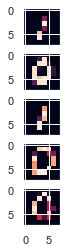

In [27]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_test[0].reshape(8,8)*255)
axarr[1].imshow(x_test[1].reshape(8,8)*255)
axarr[2].imshow(x_test[2].reshape(8,8)*255)
axarr[3].imshow(x_test[3].reshape(8,8)*255)
axarr[4].imshow(x_test[4].reshape(8,8)*255)

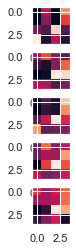

In [28]:

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(test_reduce[0].reshape(4,4)*255)
axarr[1].imshow(test_reduce[1].reshape(4,4)*255)
axarr[2].imshow(test_reduce[2].reshape(4,4)*255)
axarr[3].imshow(test_reduce[3].reshape(4,4)*255)
axarr[4].imshow(test_reduce[4].reshape(4,4)*255)

###  Descomprimir datos

Aquí recordando la aplicación del complejo conjugado de nuestra propuesta  de red tensorial  debemos acercarnos al valor original de entrada $|\phi \rangle$

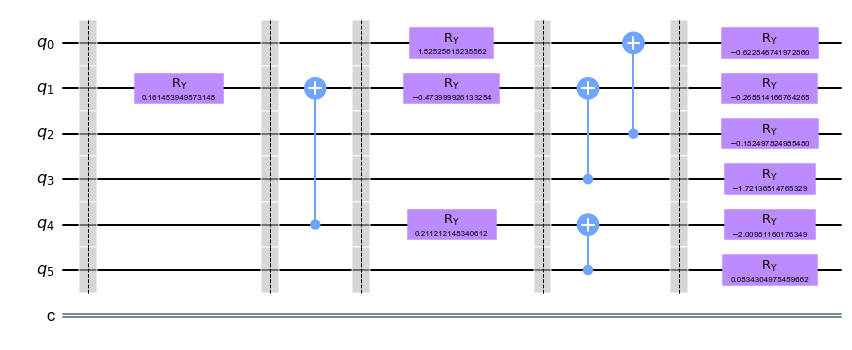

In [29]:
vqc(n,num_layers,params).inverse().draw(output = "mpl")

In [30]:
def decoder_result_test(params):
    reduce = []
    for i in range(len(test_reduce)):

        circuit_init = input_data(6,np.concatenate((np.zeros(48), test_reduce[i]), axis=0))
        circuit_vqc = vqc(n,num_layers,params).inverse()

        circuit_full = QuantumCircuit(n,n)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector()
        reduce.append(result)
    return reduce
        
decoder =decoder_result_test(params)

<Figure size 432x288 with 0 Axes>

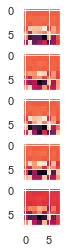

In [31]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
axarr[2].imshow(decoder[2].real.reshape(8,8)*255)
axarr[3].imshow(decoder[3].real.reshape(8,8)*255)
axarr[4].imshow(decoder[4].real.reshape(8,8)*255)

In [32]:
def decoder_result_train(params):
    reduce = []
    for i in range(len(train_reduce)):
        circuit_init = input_data(n,np.concatenate((np.zeros(48), train_reduce[i]), axis=0))
        circuit_vqc = vqc(n,num_layers,params).inverse()

        circuit_full = QuantumCircuit(n,n)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector()
        reduce.append(result)
    return reduce
        
decoder_train =decoder_result_train(params)


# métricas para comparar imagenes


De cada una de las imágenes tanto de prueba como entrenamiento se realizará las siguientes métricas para validar la capacidad de nuestro autoencoder entre las imagenes de entrada y descomprimidas. 

- Error Cuadrático medio (o por sus siglas en inglés  MSE)

$MSE=\frac{1}{m n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1}[I(i, j)-K(i, j)]^{2},$ 

donde $m$ es el  alto de la imágen $I$, n el ancho de la imagen $K$ e $i$,$j$ las posiciones $x,y$ de los píxeles de las imágenes; entre más cercano a 0 sea su valor es mejor.

- Proporción Máxima de Señal a Ruido (o por sus siglas en inglés  PSNR)

$PSNR = 10×log_{10}(\frac{(mxn)^2}{MSE},$

donde $m$ el  alto de la imagen $I$, n el ancho de la imagen $K$ y $MSE$ el error cuadrático medio;entre más alto su valor es mejor.


- Semejanza Estructural (o por sus siglas en inglés SSIM)

$    \operatorname{SSIM}(x, y)=\frac{\left(2 \mu_{x} \mu_{y}+c_{1}\right)\left(2 \sigma_{x y}+c_{2}\right)}{\left(\mu_{x}^{2}+\mu_{y}^{2}+c_{1}\right)\left(\sigma_{x}^{2}+\sigma_{y}^{2}+c_{2}\right)},$

donde $\mu$ es el promedio, $\sigma$ es la varianza y $c$ es la covarianza \cite{c1}}; peor caso -1, mejor caso 1.

In [33]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [34]:
from skimage.metrics import structural_similarity as ssim

# Comparar el conjunto de entrenamiento

Se realiza los resultados de las tres métricas en el conjunto de entrenamiento

In [35]:
import math 
ssim_list = []
mse_list = []
psnr_list = []

for i in range(len(x_train)):
    test_img = x_train[i].reshape(8,8)*255
    decoded_img = decoder_train[i].real.reshape(8,8)*255
    Y = float(mse(decoded_img,test_img))
    ssim_list.append(ssim(decoded_img.astype("float"),test_img.astype("float")))
    mse_list.append(Y)
    aux = (64**2)/Y
    psnr_list.append(10*math.log10(aux))


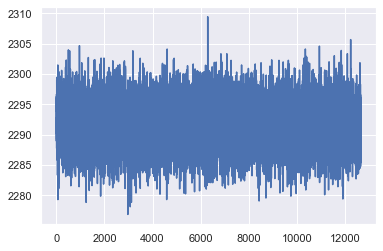

In [36]:
from matplotlib import pyplot as plt
plt.plot(mse_list)
plt.show()

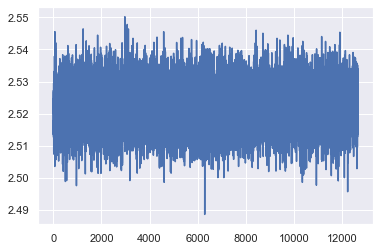

In [37]:
from matplotlib import pyplot as plt
plt.plot(psnr_list)
plt.show()

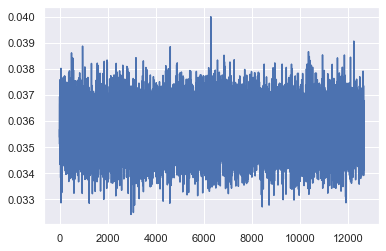

In [38]:
from matplotlib import pyplot as plt
plt.plot(ssim_list)
plt.show()

# Comparar el conjunto de prueba (Test)

Se realiza los resultados de las tres métricas en el conjunto de prueba

In [39]:
ssim_list = []
mse_list = []
psnr_list = []

for i in range(len(x_test)):
    test_img = x_test[i].reshape(8,8)*255
    decoded_img = decoder[i].real.reshape(8,8)*255
    Y = float(mse(decoded_img,test_img))
    ssim_list.append(ssim(decoded_img.astype("float"),test_img.astype("float")))
    mse_list.append(Y)
    aux = (64**2)/Y
    psnr_list.append(10*math.log10(aux))

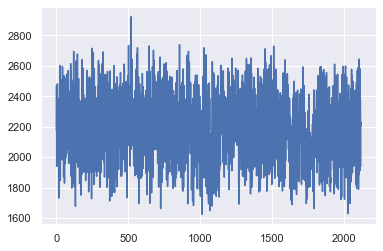

In [40]:
from matplotlib import pyplot as plt
plt.plot(mse_list)
plt.show()

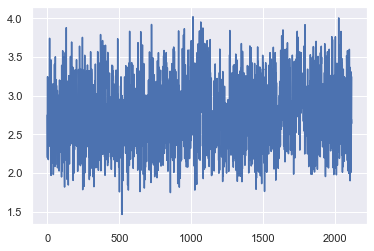

In [41]:
from matplotlib import pyplot as plt
plt.plot(psnr_list)
plt.show()

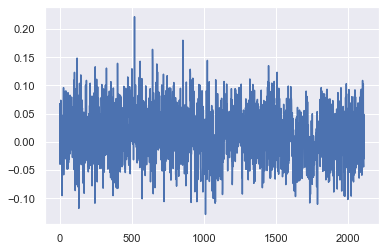

In [42]:
from matplotlib import pyplot as plt
plt.plot(ssim_list)
plt.show()

Se repite el mis proceso pero ya con eentradas no aleatorias para guardar la información en archivos csv que se ocuapran para realizar una clasificación con las imagenes reducidas.

In [43]:
(x_train_c, y_train_c), (x_test_c, y_test_c) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_c, x_test_c = x_train_c[..., np.newaxis]/255.0, x_test_c[..., np.newaxis]/255.0

In [44]:
x_train_c, y_train_c = filter_01(x_train_c, y_train_c)
x_test_c, y_test_c = filter_01(x_test_c, y_test_c)

In [45]:
x_train_c = tf.image.resize(x_train_c, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_c = tf.image.resize(x_test_c, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

In [46]:
for i in range(len(x_train_c)):
    x_train_c[i] = Normalize(x_train_c[i])
    
for i in range(len(x_test)):
    x_test_c[i] = Normalize(x_test_c[i])

In [47]:
x_train_c = x_train_c.reshape(len(x_train_small), 64)
x_test_c = x_test_c.reshape(len(x_test_small), 64)

x_train_c.shape

(12665, 64)

In [48]:
def compress_result_train(params):
    reduce = []
    for i in range(len(x_train_c)):
        circuit_init = input_data(n,x_train_c[i])
        circuit_vqc = vqc(n,num_layers,params)

        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full)
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts()
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs)
        
    return reduce
reduce_train_c = compress_result_train(params)

In [49]:
def compress_result_test(params):
    reduce = []
    for i in range(len(x_test_c)):
        circuit_init = input_data(n,x_test_c[i])
        circuit_vqc = vqc(n,num_layers,params)

        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full)
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts()
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs)
        
    return reduce
reduce_test_c = compress_result_test(params)

In [50]:
test_reduce = []
for i in reduce_test_c:
    index_image = []
    for j in range(16):
        bin_index = bin(j)[2:]
        while len(bin_index) <4:
            bin_index = '0'+bin_index 
        try:   
            index_image.append(i[bin_index])
        except:
            index_image.append(0)
    
    test_reduce.append(np.array(index_image))

In [51]:
train_reduce = []
for i in reduce_train_c:
    index_image = []
    for j in range(16):
        bin_index = bin(j)[2:]
        while len(bin_index) <4:
            bin_index = '0'+bin_index 
        try:   
            index_image.append(i[bin_index])
        except:
            index_image.append(0)
    
    train_reduce.append(np.array(index_image))

In [52]:
def decoder_result_train_c(params):
    reduce = []
    for i in range(len(train_reduce)):
        circuit_init = input_data(n,np.concatenate((np.zeros(48), train_reduce[i]), axis=0))
        circuit_vqc = vqc(n,num_layers,params).inverse()

        circuit_full = QuantumCircuit(n,n)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector()
        reduce.append(result)
    return reduce
        
decoder_train_c =decoder_result_train_c(params)
len(decoder_train_c)

12665

In [53]:
def decoder_result_test_c(params):
    reduce = []
    for i in range(len(test_reduce)):

        circuit_init = input_data(6,np.concatenate((np.zeros(48), test_reduce[i]), axis=0))
        circuit_vqc = vqc(n,num_layers,params).inverse()

        circuit_full = QuantumCircuit(n,n)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector()
        reduce.append(result)
    return reduce
        
decoder_c =decoder_result_test_c(params)

### Guardar los resultados

Se guardaron dos archivos train.csv y test.csv de las imágenes comprimidas obtenidas de nuestro autoencoder la primera para el  conjunto de entrenamiento y la segunda para el conjunto de prueba


In [54]:
import pandas as pd 



df = pd.DataFrame(train_reduce)
df[16] = y_train
df.to_csv("train_1.csv",index=False)



df = pd.DataFrame(test_reduce)
df[16] = y_test
df.to_csv("test_1.csv",index=False)


# Resultados del autoencoder cuántico

Siguiendo los resultados definimos en un histograma por métrica los mejores casos y nos dieron las siguientes gráficas


## MSE

Los resultados más cercanos al 0 son los mejores resultados, viendo de manera visual el mejor caso es con 200 imágenes.

<img src="mse.png"> 


## PSNR

Los resultados con un valor mayor en el eje de las ordenadas son los mejores resultados, observando de manera visual que el mejor caso es con 200 imágenes.
<img src="psnr.png">


## SSIM
Los resultados más cercanos a 1 son los mejores resultados, viendo de manera visual el mejor caso es con 200 imágenes.

<img src="ssim.png">



Por lo tanto consideraremos los resultados de 200 imagenes para realizar un clasificador binario.

# Parte del clasificador binario

Se importan las bibliotecas necesarias para esto usando qiskit meachine learning

In [2]:
# Scikit Imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

Se obtiene los datos de los csv tanto para poder procesar los datos en el clasificador cuántico variacional. pasando un lado el vector de entrada de tamaño 16x1 y el otro la etiqueta

In [3]:
sample_train = []
label_train = []
with open('train.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for row in reader:
        sample_train.append(row[0:-1])
        label_train.append(row[-1])
sample_train = np.array(sample_train).astype(np.float)
label_train = np.array(label_train).astype(np.float)
sample_train.shape, label_train.shape

((12665, 16), (12665,))

In [4]:
sample_test = []
label_test = []
with open('test.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for row in reader:
        sample_test.append(row[0:-1])
        label_test.append(row[-1])
sample_test = np.array(sample_test).astype(np.float)
label_test = np.array(label_test).astype(np.float)
sample_test.shape, label_test.shape

((2115, 16), (2115,))

Se genera el vector de entrada para el conjunto de entrenamiento y prueba de tamañ0 16x1 

In [4]:
sample_train = sample_train.reshape(len(sample_train), 16)
sample_test = sample_test.reshape(len(sample_test), 16)

Vamos a realizar un clasificador usando 4 qubits por lo cual hay disminuir el númeor de muestras para que nuestros dispositivos puedan correr los ejemplos, usando el método Hold-out 70-30, es decir, 70% entrenamiento y 30% de prueba.

In [5]:
train_size = 700
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 300
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

Lo siguiente es mapear el vector clasico a un estado cuántico para ello usaremos la funcion ZZFeatureMap ("Se puede ocupar otro como PauliFeatureMap o ZFeatureMap").

Despues inicializaremos un Kernel cuántico del cual podemos calcular cada elemento de esta mátriz  en una computadora cuántica calculando la amplitud de transición. Esto nos proporciona una estimación de la matriz cuántica del kernel, que luego podemos usar en un algoritmo de aprendizaje automático del kernel, es este caso se usara en una maquina de soporte vectorial

In [1]:
zz_map = ZZFeatureMap(feature_dimension=16, reps=1, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_map.draw(output="mpl")

Construimos las matrices de entrenamiento y prueba del kernel cuántico.
Para cada par de puntos de datos en el conjunto de datos de entrenamiento

In [7]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

Utilizamos las matrices de entrenamiento y prueba del kernel cuántico en un algoritmo de clasificación de máquina de vectores de soporte clásico.

In [8]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.97


Probamos el algoritmo viendo que tal hace la clasificacion del set de prueba

In [9]:
predictions = zzpc_svc.predict(matrix_test)

Como se puede observar de 300 muestaras solo 6 no se clasificaron de manera correcta

In [10]:
for prediction,label in zip(predictions,label_test):
    if(prediction != label):
        print(prediction, label)

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
1.0 0.0
0.0 1.0


## Validar para el conjunto de 200 imagenes

Se repite el mismo proceso pero considerando que el método de validación hold-out  se consideré válido se debe hacer la prueba con diferentes conjuntos de forma aleatoria que se realizará con el conjunto comprimido de 200 imágenes

In [2]:
sample_train = []
label_train = []
with open('train_200.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for row in reader:
        sample_train.append(row[0:-1])
        label_train.append(row[-1])
sample_train = np.array(sample_train).astype(np.float)
label_train = np.array(label_train).astype(np.float)

sample_test = []
label_test = []
with open('test_200.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for row in reader:
        sample_test.append(row[0:-1])
        label_test.append(row[-1])
sample_test = np.array(sample_test).astype(np.float)
label_test = np.array(label_test).astype(np.float)
sample_train.shape, label_train.shape, sample_test.shape, label_test.shape

((12665, 16), (12665,), (2115, 16), (2115,))

Se genera 7 iteraciones con diferentes imagenes de rangos fijos

In [3]:
score = []
for i in range(7):
    train_size = 700
    
    sample_train_1 = sample_train[i*train_size:(i+1)*train_size]
    label_train_1 = label_train[i*train_size:(i+1)*train_size]

    test_size = 300
    sample_test_1 = sample_test[i*test_size:(i+1)*test_size]
    label_test_1 = label_test[i*test_size:(i+1)*test_size]
    
    
    zz_map = ZZFeatureMap(feature_dimension=16, reps=1, entanglement='linear', insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
    matrix_train = zz_kernel.evaluate(x_vec=sample_train_1)
    matrix_test = zz_kernel.evaluate(x_vec=sample_test_1, y_vec=sample_train_1)
    
    zzpc_svc = SVC(kernel='precomputed')
    zzpc_svc.fit(matrix_train, label_train_1)
    zzpc_score = zzpc_svc.score(matrix_test, label_test_1)

    print(f'Precomputed kernel classification test score: {zzpc_score}')
    score.append(zzpc_score)
    del matrix_train, matrix_test

Precomputed kernel classification test score: 0.97
Precomputed kernel classification test score: 0.9366666666666666
Precomputed kernel classification test score: 0.96
Precomputed kernel classification test score: 0.9633333333333334
Precomputed kernel classification test score: 0.9833333333333333
Precomputed kernel classification test score: 0.9633333333333334
Precomputed kernel classification test score: 0.9466666666666667


El valor promedio para el conjunto que se dio del auto encoder usando Hold-out 70-30 se obtuvo  un valor de desempeño de 

In [4]:
sum(score)/len(score)

0.9604761904761905

## Autores

- Martínez Vázquez María Fernanda (undergraduate)
- Navarro Ambriz Ronaldo  (undergraduate)
- Martinez Hernandez Luis Eduardo (undergraduate)
- Galindo Reyes Agustin (undergraduate)
- Alberto Maldonado Romo (master)

# Referencias


[1] Bravo-Prieto, Carlos. (2020). Quantum autoencoders with enhanced data encoding. 

[2] Biamonte, Jacob. (2019). Lectures on Quantum Tensor Networks. 

[3] Kardashin, Andrey & Uvarov, Aleksey & Biamonte, Jacob. (2021). Quantum Machine Learning Tensor Network States. Frontiers in Physics. 8. 586374. 10.3389/fphy.2020.586374. 

[4] Stoudenmire, E. & Schwab, David. (2016). Supervised Learning with Quantum-Inspired Tensor Networks. 

[5] Liu, Ding & Yao, Zekun & Zhang, Quan. (2020). Quantum-Classical Machine learning by Hybrid Tensor Networks

[6] Romero, Jonathan & Olson, Jonathan & Aspuru-Guzik, Alán. (2016). Quantum autoencoders for efficient compression of quantum data. Quantum Science and Technology. 2. 10.1088/2058-9565/aa8072. 

[7] Foulds, Steph & Kendon, Viv & Spiller, Tim. (2020). The controlled SWAP test for determining quantum entanglement. 